# Train model with dense neural network approach

## Initialize dataset for model training and evaluation

In [1]:
# control if using sampled or original data
import joblib
from config import TRAIN_TEST_SPLIT_ELECTRIC_FILE, TRAIN_TEST_SPLIT_ELECTRIC_FILE_SAMPLED

is_sampled = False

In [2]:
# load data
if is_sampled:
    X_train, X_test, y_train, y_test = joblib.load(TRAIN_TEST_SPLIT_ELECTRIC_FILE_SAMPLED)
else:
    X_train, X_test, y_train, y_test = joblib.load(TRAIN_TEST_SPLIT_ELECTRIC_FILE)

In [3]:
# temporary reduce the size of the dataset for testing
# X_train = X_train[:1000]
# y_train = y_train[:1000]
# X_test = X_test[:1000]
# y_test = y_test[:1000]

In [4]:
# example prints to validate correct output
X_train.head(2)

,member_state_AT,member_state_BE,member_state_BG,member_state_CY,member_state_CZ,member_state_DE,member_state_DK,member_state_EE,member_state_ES,member_state_FI,...,commercial_name_iX3,commercial_name_other,category_of_vehicle_M1,category_of_vehicle_M1,category_of_vehicle_M1G,category_of_vehicle_N1,mass_vehicle,engine_power,year,electric_range
2349347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.435929,0.916329,1.023808,0.436143
1270572,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.775093,0.065619,-0.229645,0.146002


In [5]:
X_train.shape

(2661120, 298)

## Train Dense Neural Network model with tensorflow keras

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from config import ELECTRIC_NN_CKPT_MODEL_FILE, ELECTRIC_NN_MODEL_FILE
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
# Instantiate the model
inputs = Input(shape=(X_train.shape[1],))

# Dense with relu as activation function for regression problem -> Multiple layers but sequentially reducing number of units
# BatchNormalization: Normalizes activations to stabilize training.
# Dropout: Prevents overfitting by randomly disabling neurons.

# ---
# -> Model was overfitting with this configuration
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
# ---
# x = Dense(64, activation='relu')(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
# x = Dropout(0.4)(x)
# ---
outputs = Dense(1)(x)  # Regression -> No activation function

# Create model
model = Model(inputs=inputs, outputs=outputs)

In [8]:
# display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 298)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        38,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 49,025 (191.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
# loss: MSE (Mean Squared Error)
# metric: MAE (Mean Absolute Error)

In [10]:
# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss stops improving
    patience=15,         # Wait 10 epochs before stopping
    restore_best_weights=True  # Load best weights after stopping
)

model_checkpoint = ModelCheckpoint(
    ELECTRIC_NN_CKPT_MODEL_FILE,  # File to save the best model
    monitor='val_loss',  # Save model when val_loss improves
    save_best_only=True  # Only save the best version
)



In [ ]:
# Train the model
model_history = model.fit(
    X_train, y_train,
    epochs=100,  # 50
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 173s 3ms/step - loss: 213.0271 - mae: 7.1898 - val_loss: 1551.6443 - val_mae: 3.0769
Epoch 2/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 166s 3ms/step - loss: 42.4530 - mae: 3.7205 - val_loss: 1318.9360 - val_mae: 3.5839
Epoch 3/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 160s 2ms/step - loss: 38.2059 - mae: 3.4688 - val_loss: 1083.6815 - val_mae: 2.8940
Epoch 4/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 170s 3ms/step - loss: 34.2536 - mae: 3.2934 - val_loss: 1456.9136 - val_mae: 2.5649
Epoch 5/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 168s 3ms/step - loss: 32.4054 - mae: 3.1793 - val_loss: 10146.5654 - val_mae: 3.1781
Epoch 6/100
66528/66528 ━━━━━━━━━━━━━━━━━━━━ 168s 3ms/step - loss: 32.3683 - mae: 3.1263 - val_loss: 11136.4961 - val_mae: 3.4403
Epoch 7/100
66526/66528 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4851 - mae: 3.0595

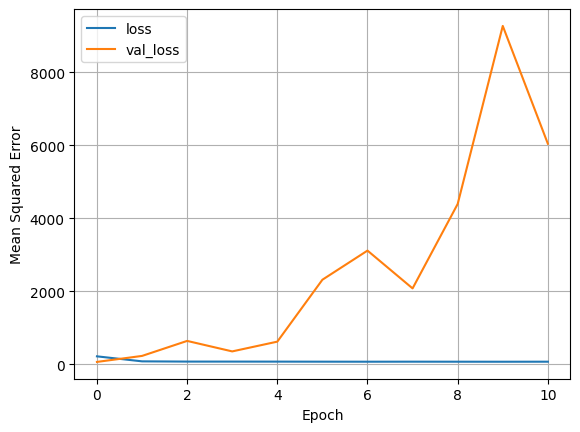

'\nInterpretation:\nIdeal Case (Good Fit)\n- loss and val_loss both decrease smoothly.\n- They converge to a stable value without diverging.\n- Small gap between loss and val_loss.\n\nUnderfitting (Not Learning Well)\n- Both loss and val_loss remain high.\n- They don\'t decrease much, meaning the model is too simple.\n\nOverfitting (Memorizing Training Data)\n- loss keeps decreasing, but val_loss starts increasing after some epochs.\n- The model performs well on training data but poorly on validation data."\n'

In [ ]:
# display loss evolution

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(model_history)

"""
Interpretation:
Ideal Case (Good Fit)
- loss and val_loss both decrease smoothly.
- They converge to a stable value without diverging.
- Small gap between loss and val_loss.

Underfitting (Not Learning Well)
- Both loss and val_loss remain high.
- They don't decrease much, meaning the model is too simple.

Overfitting (Memorizing Training Data)
- loss keeps decreasing, but val_loss starts increasing after some epochs.
- The model performs well on training data but poorly on validation data."
"""

In [ ]:
# Store model
joblib.dump(model, ELECTRIC_NN_MODEL_FILE)

['files/output/models/electric-nn_model.keras']

## Evaluate results of DNN Model

In [ ]:
# Evaluate preditions
# test_results = model.evaluate(X_test, y_test, verbose=0)
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f'Model, error (mae): {mae:5.2f}')
print(f'Model, loss (mse): {loss:5.2f}')

35641/35641 - 42s - 1ms/step - loss: 65.6893 - mae: 4.4017
Model, mae: 440.17%
Model, loss: 65.69%


In [ ]:
# Predict against test data
y_pred = model.predict(X_test).flatten()


35641/35641 ━━━━━━━━━━━━━━━━━━━━ 33s 917us/step


### Compare predicted vs. actual values

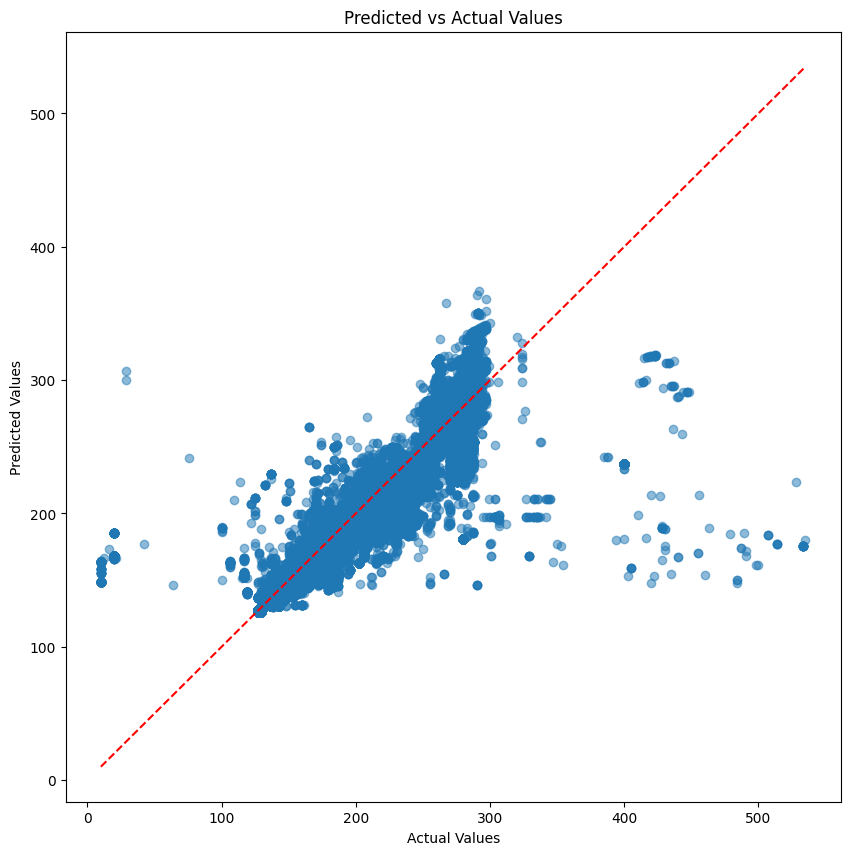

In [ ]:
# Scatter Plot
# Plot predicted vs. actual values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

### Analyze residuals and their distribution

In [ ]:
residuals = y_test - y_pred

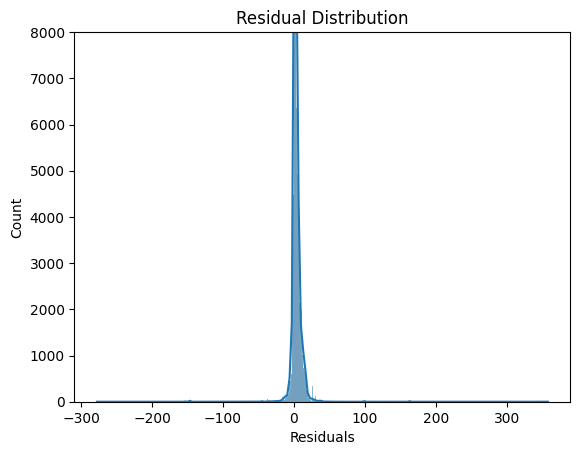

In [ ]:
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.ylim([0, 8000])
plt.show()